In [ ]:


library("readr")
library("dplyr")
library("tidyr")
library("purrr")
library("corrplot")
library("stringr")
library("ROCR")
library("ggplot2")
library("gridExtra")
install.packages("caret")
library("caret")
install.packages("kableExtra")
library("kableExtra")

# This function calculates the confusion matrix
cm <- function(model, data, target){
confusionMatrix(predict(model, newdata = data), target)
}

# This function identifies and plots the best probability cutoff values by maximizing tpr and fpr values from the ROC plot
roc_cutoff <- function(model, data, target) {
# Check for the stack models
if(str_detect(deparse(substitute(model)),'stack')) {
pred <- predict(model, data, type = "prob") %>% data.frame(No = ., Yes = 1 -.)
pred <- pred[,1]
}
else{
pred <- predict(model, data, type = 'prob')[,2]
}
# ROCR considers the later level to be the positive class.
pred <- prediction(pred, target, label.ordering = c("No","Yes"))
eval <- performance(pred, "tpr","fpr")
plot(eval)

# maximize the TPR and FPR
max <- which.max(slot(eval,"y.values")[[1]] +  1 - slot(eval,"x.values")[[1]])
# get the best cutoff value
cutoff <- slot(eval, "alpha.values")[[1]][max]
tpr <- slot(eval, "y.values")[[1]][max]
fpr <- slot(eval, "x.values")[[1]][max]
abline(h = tpr, v = fpr, lty = 2, col = "blue") # best cutoff
text(0.7,0.2, paste0("At best cutoff = ", round(cutoff,2)), col = "blue")
# Default cutoff
default <- last(which(slot(eval, "alpha.values")[[1]] >= 0.5))
defaulty <- slot(eval,"y.values")[[1]][default]
defaultx <- slot(eval,"x.values")[[1]][default]
abline(h = defaulty, v = defaultx, col = "red", lty = 2) # Default cutoff
text(0.7,0.3, paste0("At default cutoff = ", 0.50), col = "red")
return(cutoff)
}

# Find the missing values in the columns of the dataframe
missing_values <- function(df){

missing <- df %>% gather(key = "key", value = "value") %>% mutate(is.missing = is.na(value)) %>%
  group_by(key) %>% mutate(total = n()) %>%
  group_by(key, total, is.missing) %>%
    summarise(num.missing = n()) %>%
    mutate(perc.missing = num.missing/total * 100) %>% ungroup()

  return(missing)
}

# Plot add on services
plot_addon_services <- function(df,group_var){
  # Filter customers who have internet at home
  withInternet <- df %>% filter(InternetService %ni% c("No"))
  # Group by Churn and add on service var and calculate the Percentage of customers
  withInternet %>% group_by(Churn, !! sym(group_var)) %>% tally(name = "count") %>%
    mutate(Percent = count /nrow(withInternet)) %>%
    mutate(Percent = round(Percent,2)) %>%
    # Plot the percentage and Churn behaviour of each group
    ggplot(aes(x = !! sym(group_var), y = Percent, fill = Churn)) + geom_bar(stat = "identity") +
    geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) +
    theme_minimal() + scale_fill_brewer(palette="Dark2") +
    scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))
}

'%ni%' <- Negate('%in%')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
churn <- read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(churn)

Rows: 7043 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): customerID, gender, Partner, Dependents, PhoneService, MultipleLin...
dbl  (4): SeniorCitizen, tenure, MonthlyCharges, TotalCharges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 7,043 × 21
   customerID gender SeniorCitizen Partner Dependents tenure PhoneService
   <chr>      <chr>          <dbl> <chr>   <chr>       <dbl> <chr>       
 1 7590-VHVEG Female             0 Yes     No              1 No          
 2 5575-GNVDE Male               0 No      No             34 Yes         
 3 3668-QPYBK Male               0 No      No              2 Yes         
 4 7795-CFOCW Male               0 No      No             45 No          
 5 9237-HQITU Female             0 No      No              2 Yes         
 6 9305-CDSKC Female             0 No      No              8 Yes         
 7 1452-KIOVK Male               0 No      Yes            22 Yes         
 8 6713-OKOMC Female             0 No      No             10 No          
 9 7892-POOKP Female             0 Yes     No             28 Yes         
10 6388-TABGU Male               0 No      Yes            62 Yes         
# ℹ 7,033 more rows
# ℹ 14 more variables: MultipleLines <chr>, InternetService <chr>,
# 

In [ ]:
# Map "No internet service to No"

recode <- c("OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "MultipleLines")

churn <- as.data.frame(churn)

for (col in recode) {
  churn[,col] <- as.character(churn[,col])
  temp <- if_else(churn[,col] %in% c("No internet service","No phone service"), "No",churn[,col])
churn[,col] <- as.factor(temp)
}

# Remove (automatic) from PaymentMethod
churn$PaymentMethod <- str_remove(churn$PaymentMethod, "\\(automatic\\)") %>% str_trim(., side = "right") %>% as.factor()

# Does not make sense to have senior citizen as numbers.
churn$SeniorCitizen <- as.factor(recode(churn$SeniorCitizen, "1" = "Yes", "0" = "No"))

# Make tenure as categorical variable for easier ploting
churn <- churn %>% mutate(tenure_group = case_when(tenure <= 12 ~ "0-12M",
                                           tenure >12 & tenure <=24 ~ "12-24M",
                                           tenure > 24 & tenure <= 48 ~ "24-48M",
                                           tenure > 48 & tenure <= 60 ~ "48-60M",
                                           tenure >60 ~ ">60M"
                ))
churn$tenure_group <- as.factor(churn$tenure_group)

# Remove columns not needed

churn <- churn %>% select(-one_of(c("customerID")))

# Turn character columns to factor
recode <- churn %>% select_if(is.character) %>% colnames()

for(col in recode){
  churn[,col] <-  as.factor(churn[,col])

}

## Look at the unique values after cleaning

churn[-1] %>% select_if(is.factor) %>% map(function(x) unique(x))

$SeniorCitizen
[1] No  Yes
Levels: No Yes

$Partner
[1] Yes No 
Levels: No Yes

$Dependents
[1] No  Yes
Levels: No Yes

$PhoneService
[1] No  Yes
Levels: No Yes

$MultipleLines
[1] No  Yes
Levels: No Yes

$InternetService
[1] DSL         Fiber optic No         
Levels: DSL Fiber optic No

$OnlineSecurity
[1] No  Yes
Levels: No Yes

$OnlineBackup
[1] Yes No 
Levels: No Yes

$DeviceProtection
[1] No  Yes
Levels: No Yes

$TechSupport
[1] No  Yes
Levels: No Yes

$StreamingTV
[1] No  Yes
Levels: No Yes

$StreamingMovies
[1] No  Yes
Levels: No Yes

$Contract
[1] Month-to-month One year       Two year      
Levels: Month-to-month One year Two year

$PaperlessBilling
[1] Yes No 
Levels: No Yes

$PaymentMethod
[1] Electronic check Mailed check     Bank transfer    Credit card     
Levels: Bank transfer Credit card Electronic check Mailed check

$Churn
[1] No  Yes
Levels: No Yes

$tenure_group
[1] 0-12M  24-48M 12-24M >60M   48-60M
Levels: >60M 0-12M 12-24M 24-48M 48-60M

Warning message:
“attributes are not identical across measure variables; they will be dropped”
`summarise()` has grouped output by 'key', 'total'. You can override using the
`.groups` argument.


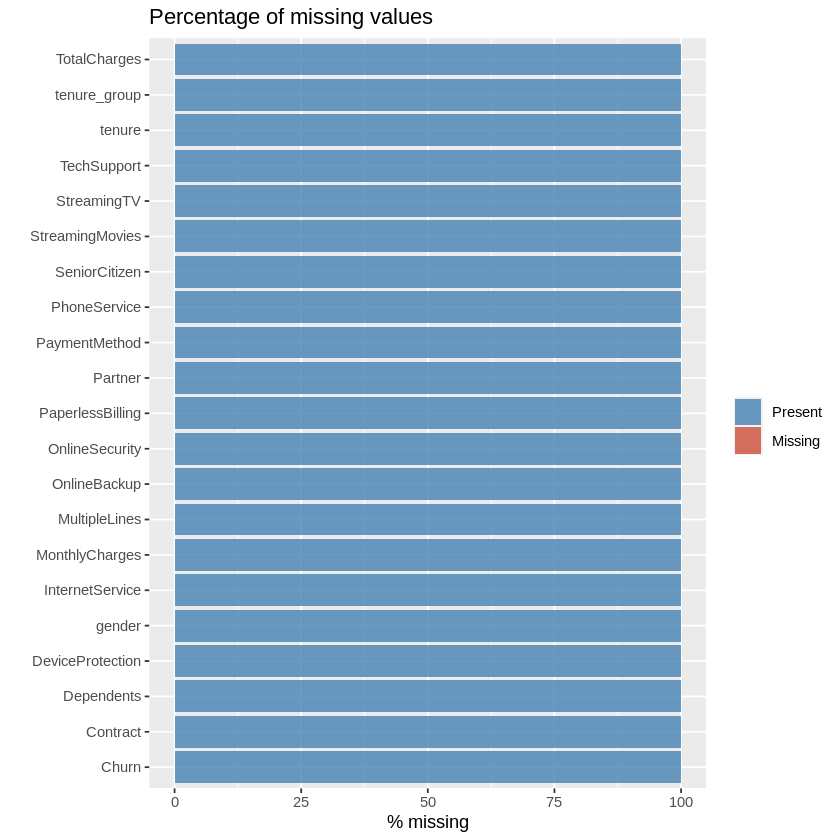

In [ ]:
# Call missing_values function
missing <- missing_values(churn)

p1 <- ggplot(missing) + geom_bar(aes( x= reorder(key, desc(perc.missing)), y = perc.missing, fill = is.missing), stat = 'identity', alpha = 0.8) + scale_fill_manual(name = "", values = c('steelblue','tomato3'), label = c("Present", "Missing")) + coord_flip() + labs(title = "Percentage of missing values",x = '',y = '% missing')

# Plot missing values
p1

# remove rows with missing values
churn <- na.omit(churn)

In [ ]:
print("Percentage of customers churn")
prop.table(table(churn$Churn))

[1] "Percentage of customers churn"



      No      Yes 
0.734215 0.265785 

# **Correlation plot**

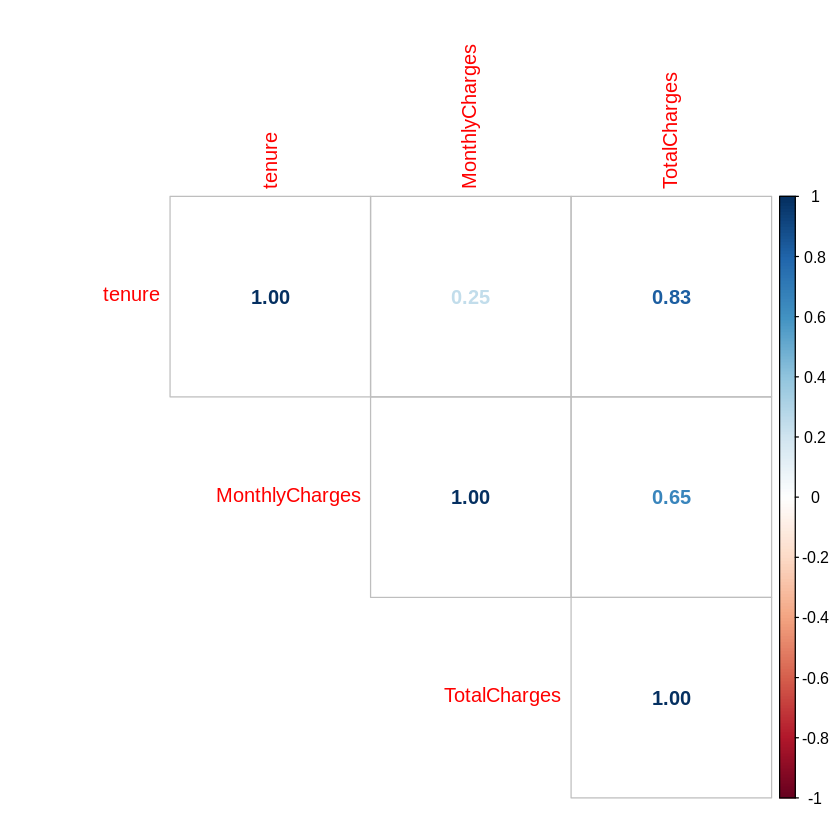

In [ ]:
# Correlation matrix of numeric variables
cor_matrix<- churn %>% select_if(is.numeric) %>% cor()

corrplot(cor_matrix,method = "number", type = "upper")

## **Grammatical and graphical plot**

`summarise()` has grouped output by 'gender'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'SeniorCitizen'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Partner'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Dependents'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'PhoneService'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'MultipleLines'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'InternetService'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'OnlineSecurity'. You can override using
the `.groups` argument.


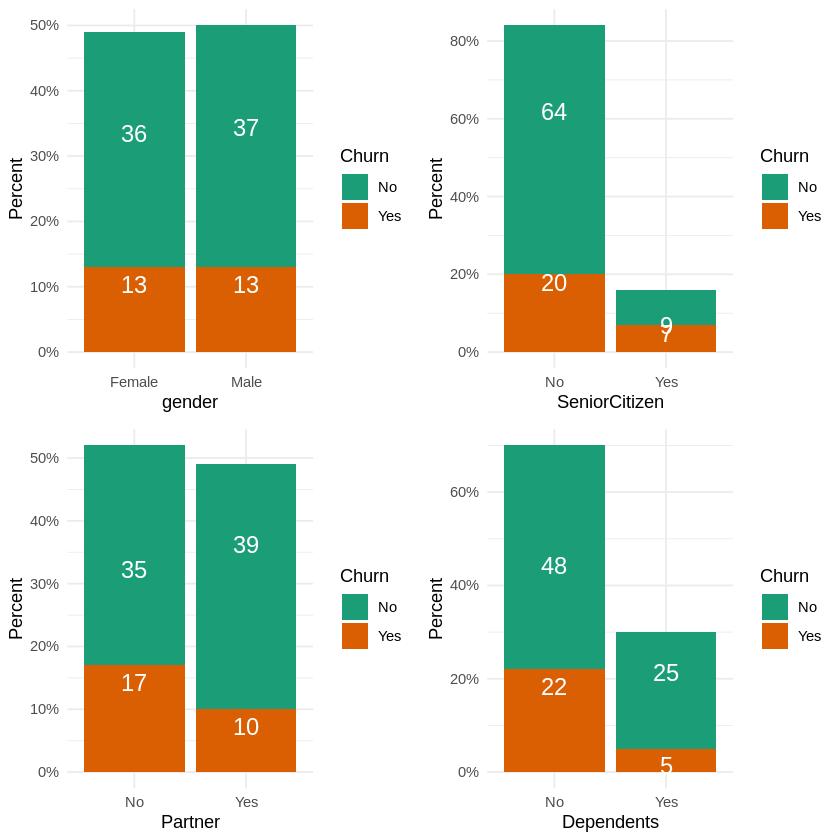

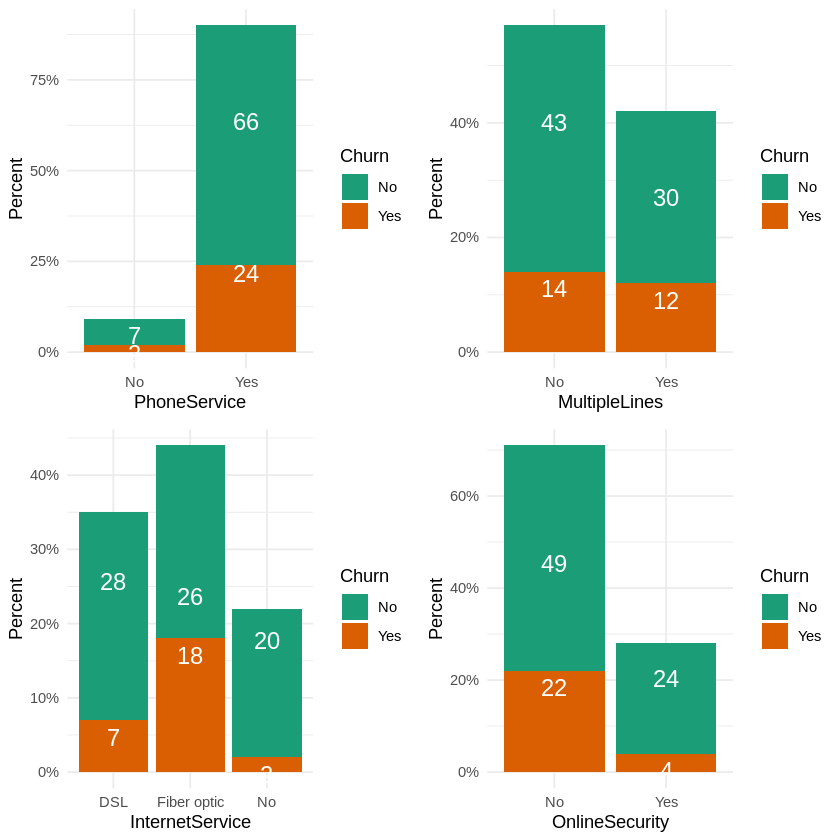

In [ ]:
p1 <- churn %>% group_by(gender, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = gender, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p2 <- churn %>% group_by(SeniorCitizen, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = SeniorCitizen, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.0, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p3 <- churn %>% group_by(Partner, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = Partner, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p4 <- churn %>% group_by(Dependents, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = Dependents, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p5 <- churn %>% group_by(PhoneService, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = PhoneService, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.0, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p6 <- churn %>% group_by(MultipleLines, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = MultipleLines, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p7 <- churn %>% group_by(InternetService, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = InternetService, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p8 <- churn %>% group_by(OnlineSecurity, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = OnlineSecurity, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

grid.arrange(p1, p2, p3, p4, ncol=2)
grid.arrange(p5, p6, p7, p8, ncol = 2)

**Does gender makes a differnce?** Does not seem to play any significant role in predicting customer churn.

**How does Senior Citizen behave?** Almost 50% of the total Senior citizens population churn. Company to could come up with offers specifically catering for senior citizen demands.

**Does having a partner makes a differnece?** It seems like customers without a partner are more likely to churn than with customers with the partner.

**Effect of dependents?** Customers with dependents are more likely to stay than without. However, customers with dependents are only 30% of the total customer population.

Phone service Customers without phone phone service are less likely to churn however, they form only 9% of the total customers

Multiple lines I don't know what multiple lines mean. However, it seems that customers with multiple lines are more likely to churn.

Cutomers with Internet services It is very interesting to see that of all the customers the customers with Fiber optic internet service at home are highly prone to churning.

Customers with Online security Customers with online security are more likely to churn.

`summarise()` has grouped output by 'OnlineBackup'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'DeviceProtection'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'TechSupport'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'StreamingTV'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'StreamingMovies'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'Contract'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'PaperlessBilling'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'PaymentMethod'. You can override using the
`.groups` argument.


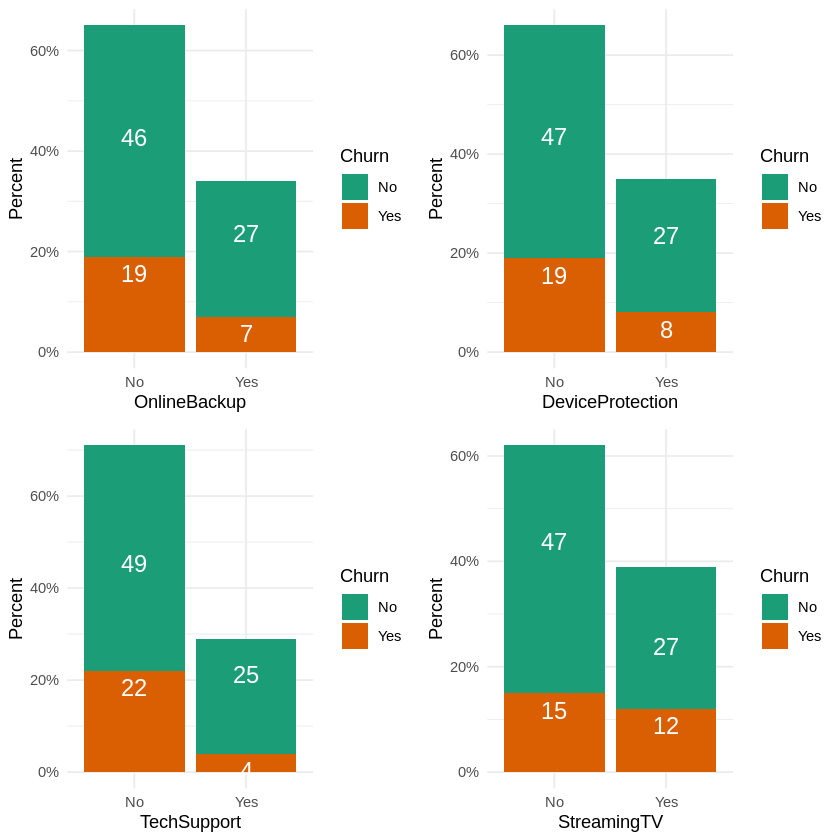

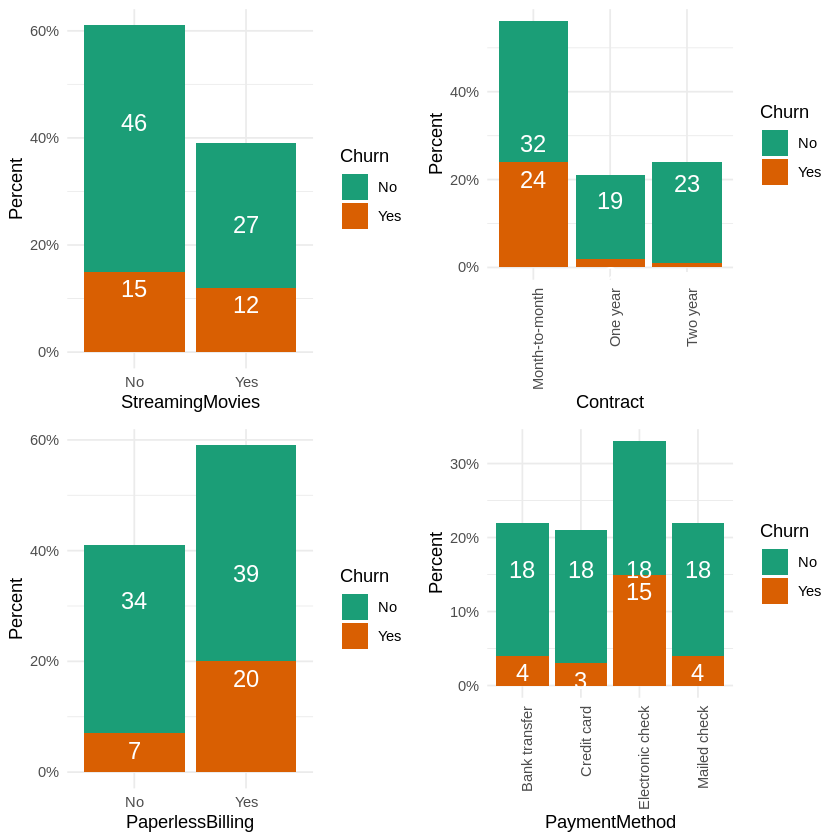

In [ ]:
p1 <- churn %>% group_by(OnlineBackup, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = OnlineBackup, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))


p2 <- churn %>% group_by(DeviceProtection, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = DeviceProtection, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p3 <- churn %>% group_by(TechSupport, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = TechSupport, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p4 <- churn %>% group_by(StreamingTV, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = StreamingTV, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p5 <- churn %>% group_by(StreamingMovies, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = StreamingMovies, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p6 <- churn %>% group_by(Contract, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = Contract, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1)) + theme(axis.text.x = element_text(angle = 90, hjust = 1))

p7 <- churn %>% group_by(PaperlessBilling, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = PaperlessBilling, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1))

p8 <- churn %>% group_by(PaymentMethod, Churn) %>% summarise(Percent = round(n()/nrow(.),2)) %>% ggplot(aes(x = PaymentMethod, y = Percent, fill = Churn)) + geom_bar(stat = "identity") + geom_text(aes(label = Percent * 100), vjust = 1.5, hjust = 0.5,color = "white", size = 5.0) + theme_minimal() + scale_fill_brewer(palette="Dark2") + scale_y_continuous(labels = scales::percent_format(accuracy = 1)) + theme(axis.text.x = element_text(angle = 90, hjust = 1))

grid.arrange(p1, p2, p3, p4, ncol=2)
grid.arrange(p5, p6, p7, p8, ncol = 2)

What is the effect of internet addons on customer churning?

Online backup and Device Protection service: Customers with online backup and device propection service are less likely to churn. They like these add ons.

Technical support Customers who opt for technical support are less likely to churn. Although less customers opt for technical support service however if they do they seem to stay the company.

Does Streaming services help retain customers? It does not look like that customers who opt for streaming services are more likely to stay infact it they are more prone to churning.

What about Contract period? Very interesting pattern. If the company is able to engage customers in 1 year or more contract customers are almost certain to stay.

Paperless billing. It is interesting to see that customers who opt for paperless billing service are more likely to churn. It may be due to the fact that people tend to forget paying bills if bill is hiding somewhere in their email or sms therefore, end up paying more which make them unhappy with company and they churn.

Payment method Very interesting pattern. Of all the customers paying bills through electronic check almost half of the customers churn. It may be due to the bad experience like bouncing of checks or some error on the company's part in processing check payments.

 **Some other interesting plots
Let us take a deeper look at the popularity of add on services such as Tech Support, Streaming Movies, Online backup etc. for the customers who have internet at home. For this we will filter out customers who have internet at home.**

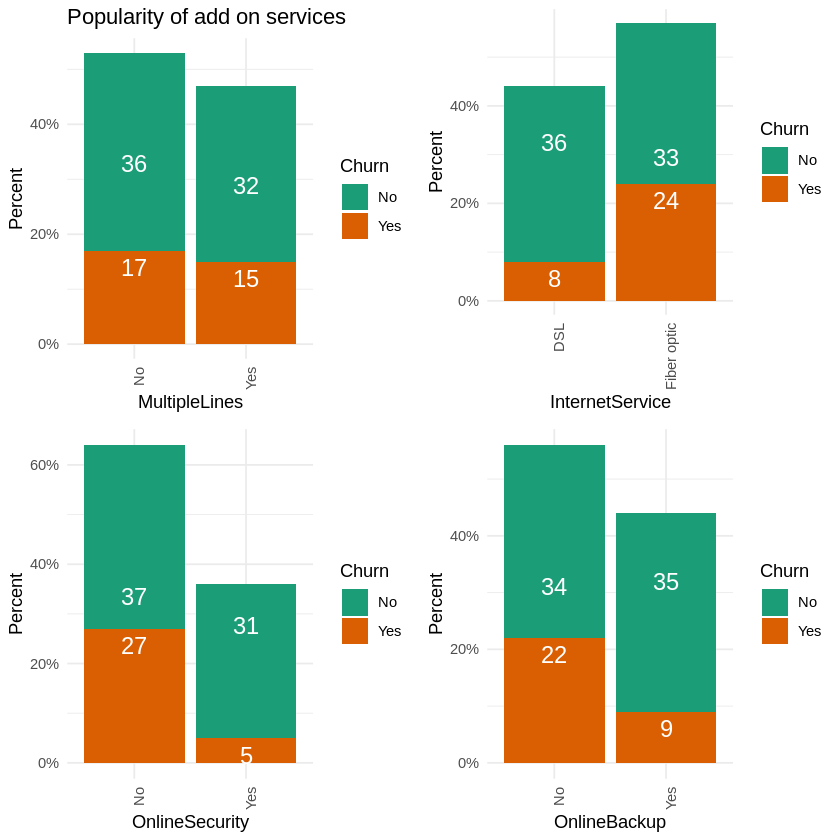

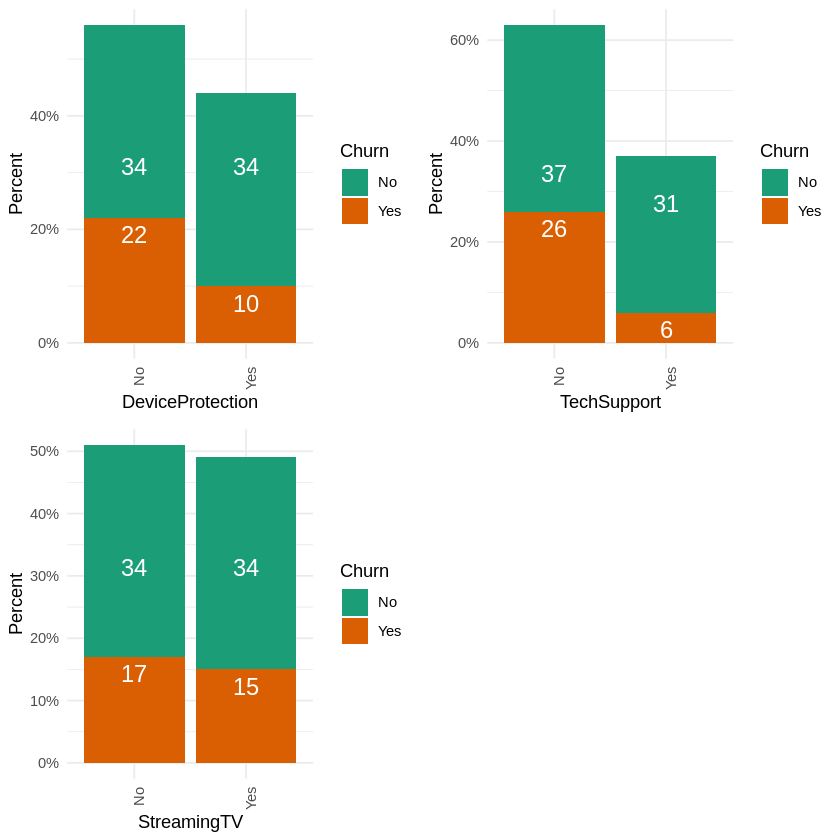

In [ ]:
# Create an adds on vector
adds_on <- names(churn)[7:13]

addson_plots <- map(adds_on, plot_addon_services, df = churn)

p1 <- addson_plots[[1]] + ggtitle("Popularity of add on services")
p2 <- addson_plots[[2]]
p3 <- addson_plots[[3]]
p4 <- addson_plots[[4]]
p5 <- addson_plots[[5]]
p6 <- addson_plots[[6]]
p7 <- addson_plots[[7]]

grid.arrange(p1, p2, p3, p4, ncol=2)
grid.arrange(p5, p6, p7, ncol = 2)

**Internet service:** Customers with Fiber optic service are more prone to churning than DSL service. It may be because DSL service may not be fast enough and customers use telco's internet and therefore less likely to churn.

**Online security & Online backup:** Customers who do not have Online security or backup service are more likely to churn.

**Device Protection and Tech Support:** Similarly customers who do not opt for device protection and tech support are more likely to churn.

**Streaming services:** Streaming services do not significantly make a difference in customer churn behavour.

**Additionally, we also see that popularity of services is in the order StreamingMovies > StreamingTV > OnlineBackup > Device Protection > Tech support > Online security.**

**Monthly charges paid by customers**
Lets look at how much on average monthly charges are paid by customers who churn. My guess is customers who churn are paying higher monthly charges than customers who do not churn.

# **Box Plot**

`summarise()` has grouped output by 'gender', 'tenure_group'. You can override
using the `.groups` argument.


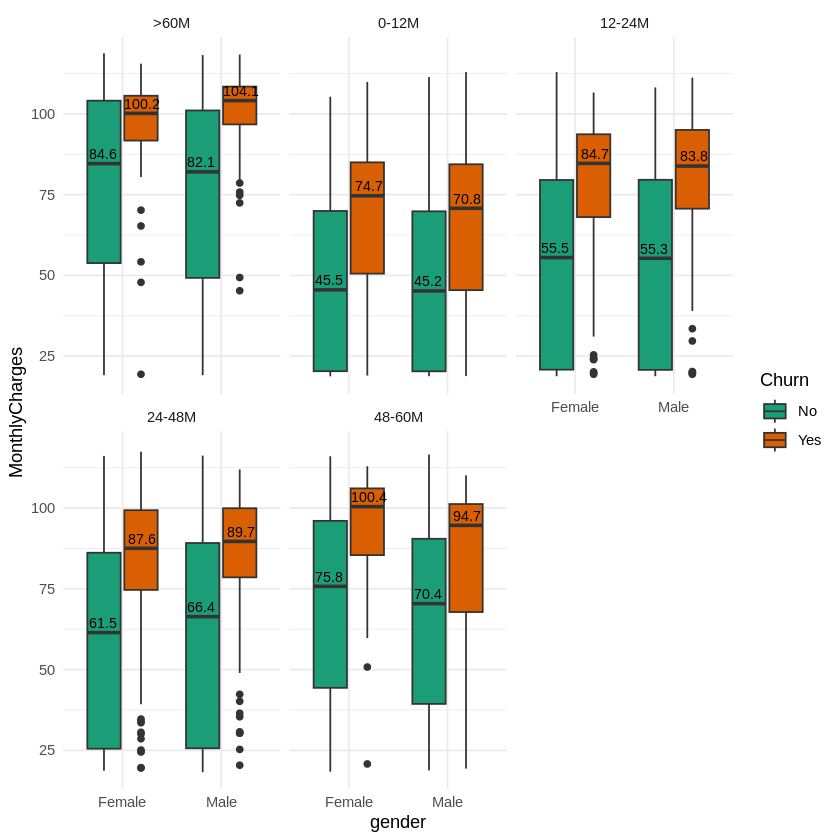

In [ ]:
df <- churn %>% group_by(gender, tenure_group, Churn) %>%
   summarise(mean = median(MonthlyCharges)) %>% arrange(tenure_group)
# Define the x positions for plotting text
df$x <- rep(c(0.8,1.2,1.8,2.2),5)

churn %>% ggplot(aes(y = MonthlyCharges,  x= gender, fill = Churn)) +
    geom_boxplot() + facet_wrap(~tenure_group) +
  geom_text(data = df, aes(label = round(mean, 1), y = mean + 3.0, x = x), size = 3) +
  theme_minimal() + scale_fill_brewer(palette="Dark2")